# Question 1 Learning long term dependencies

In [1]:
# %run MyOtherNotebook.ipynb # run auxillary scripts

#### Question: Describe the architecture used for LSTM and for RNN. Please also describe activation functions used, learning rate.

#### RNN
- An RNN is a recurrent neural network whose hidden state at time t is calculated using the hidden state at time t-1 in addition to the input at time t in order to 

  $$ h_t = \tanh(x_t W_{ih}^T + b_{ih} + h_{t-1}W_{hh}^T + b_{hh}) $$
  
where $h_t$ is the hidden state at time t, $x_t$x is the input at time t, and $h_{(t-1)}$ is the hidden state of the previous layer at time t-1 or the initial hidden state at time 0. 

- Our network consists of an input layer of size p+1 which is the input of the RNN, we apply tanh activation (ReLU can also be used, but results are displayed with tanh). The initial hidden state is simply a zero vector. The output of the RNN layer is output, h_n where h_n is the hidden state at time n. We supply this output to a linear (Dense) layer whose output is of the shape p+1 (the predicted target, which can be x or y).
- The input size is p+1 = 101, hidden size is 128, activation function used is tanh.
- learning_rate used is 0.01 (can be changed, results are displayed with 0.01 as default)

#### LSTM
- LSTM is a long short term memory cell. It is an RNN but there are additional components present such as a forget gate, selective read and selective write. These operations are modelled after a 'whiteboard' such that information can be selectively erased or forgotten in order to prevent information at time t-N being completely overwritten beyond recognition, i.e., 'lost' at time t. The equation is as follows:
    
$$
        \begin{array}{ll} \\
            i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
            f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
            g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
            o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
            c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
            h_t = o_t \odot \tanh(c_t) \\
        \end{array}
$$

where $h_t$ is the hidden state at time $t$, $c_t$ is the cell
state at time $t$, $x_t$ is the input at time $t$, $h_{t-1}$
is the hidden state of the layer at time $t-1$ or the initial hidden
state at time $0$, and $i_t$, $f_t$, $g_t$,
$o_t$ are the input, forget, cell, and output gates, respectively.
$\sigma$ is the sigmoid function, and $\odot$ is the Hadamard product.

- Our network consists of an input layer of size p+1 which is the input to the LSTM layer, we apply the equation as described above to our input. The initial hidden state is simply a zero vector. The layer returns the output of the LSTM and the tuple (h_n, c_n) which is the hidden state at time n and the cell state at time n. We supply this output to a linear (Dense) layer whose output size is p+1 (the predited target, x or y).
- The input size is p+1 = 101, hidden size is 128, activation function used is tanh (ReLU can also be used, but results are displayed with tanh).
- learning_rate used is 0.01 (can be changed, results are displayed with 0.01 as default)


In [2]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

def generate_samples(p, n_batches, batch_size):
    x_inputs_indices = np.sort(np.random.randint(low=0, high=p-2, size=[n_batches,batch_size,p-1], dtype=int))
    x_p_indices = np.ones((n_batches,batch_size,1),dtype=np.int32)*(p-1)
    x_inputs_indices = np.dstack((x_p_indices,x_inputs_indices,x_p_indices))

    # y indices
    y_inputs_indices = np.sort(np.random.randint(low=0, high=p-2, size=[n_batches,batch_size,p-1], dtype=int))
    y_p_indices = np.ones((n_batches,batch_size,1),dtype=np.int32)*(p)
    y_inputs_indices = np.dstack((y_p_indices,y_inputs_indices,y_p_indices))

    x_inputs = np.zeros((n_batches,batch_size,p+1,p+1), dtype=np.int32) # batch_size, timesteps, features
    for k in range(n_batches):
        for i in range(batch_size):
            for j in range(p+1):
                x_inputs[k][i][j][x_inputs_indices[k][i][j]] = 1

    y_inputs = np.zeros((n_batches,batch_size,p+1,p+1), dtype=np.int32) # batch_size, timesteps, features
    for k in range(n_batches):
        for i in range(batch_size):
            for j in range(p+1):
                y_inputs[k][i][j][y_inputs_indices[k][i][j]] = 1
    
    return x_inputs, y_inputs

In [4]:
def generate_inputs_labels(p, n_batches, batch_size):
    x_inputs, y_inputs = generate_samples(p, n_batches, batch_size)
    
    inputs = []
    labels = []
    for k in range(n_batches):
        inputs.append([])
        labels.append([])
        for j in range(batch_size):
            inputs[k].append(x_inputs[k][j][0:100])
            labels[k].append(np.squeeze(x_inputs[k][j][100:101]))
        inputs[k] = np.array(inputs[k])
        labels[k] = np.array(labels[k])

    inputs = np.array(inputs)
    labels = np.array(labels)

    inputs = torch.from_numpy(inputs)
    labels = torch.from_numpy(labels)
    inputs_x,labels_x = inputs.type(torch.FloatTensor),labels.type(torch.LongTensor)


    inputs = []
    labels = []
    for k in range(n_batches):
        inputs.append([])
        labels.append([])
        for j in range(batch_size):
            inputs[k].append(y_inputs[k][j][0:100])
            labels[k].append(np.squeeze(y_inputs[k][j][100:101]))
        inputs[k] = np.array(inputs[k])
        labels[k] = np.array(labels[k])

    inputs = np.array(inputs)
    labels = np.array(labels)

    inputs = torch.from_numpy(inputs)
    labels = torch.from_numpy(labels)
    inputs_y,labels_y = inputs.type(torch.FloatTensor),labels.type(torch.LongTensor)
    
    return inputs_x,labels_x,inputs_y,labels_y


In [5]:
# generate 3200 training samples in batches of size 32 for both x and y sequences
p = 100 # time steps
n_batches = 100
batch_size = 32

# get inputs and labels
inputs_x,labels_x,inputs_y,labels_y = generate_inputs_labels(p, n_batches, batch_size)

In [6]:
# hyper parameters
input_size = p+1 # we have a p+1 dimensional vector for each time step
hidden_size = 128
num_epochs = 10
# batch_size = 32
learning_rate = 0.01

In [7]:
class RecurrentNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RecurrentNeuralNet, self).__init__()
        self.rnn = nn.RNN(input_size=input_size,hidden_size=hidden_size,batch_first=True)
        self.l1 = nn.Linear(hidden_size, p+1)
    
    def forward(self, x):
        out,h_n = self.rnn(x)
        out = self.l1(out)
        
        return out


In [8]:
class LSTMNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMNeuralNet, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,hidden_size=hidden_size,batch_first=True)
        self.l1 = nn.Linear(hidden_size, p+1)
    
    def forward(self, x):
        out,(h_n,c_n) = self.lstm(x)
        out = self.l1(out)
        
        return out


In [9]:
class GRUNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRUNeuralNet, self).__init__()
        self.gru = nn.GRU(input_size=input_size,hidden_size=hidden_size,batch_first=True)
        self.l1 = nn.Linear(hidden_size, p+1)
    
    def forward(self, x):
        out,h_n = self.gru(x)
        out = self.l1(out)
        
        return out


In [10]:
model_rnn = RecurrentNeuralNet(input_size, hidden_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=learning_rate)

In [11]:
# training_loop
rnn_loss_lis = []
rnn_step_lis = []

rnn_num_inputs = []
rnn_input_loss = []
steps = 1
n_total_steps = len(inputs_x)
for epoch in range(num_epochs):
    lsum = 0
    for i in range(len(inputs_x)):
        if np.random.choice([0,1]) == 0:
            inp = inputs_x[i]
            lab = labels_x[i]
        else:
            inp = inputs_y[i]
            lab = labels_y[i]
            
        
        # forward
        outputs =  model_rnn(inp)
        loss = criterion(outputs, lab)
        rnn_num_inputs.append(steps)
        rnn_input_loss.append(loss.item())
        # backwards 
        optimizer.zero_grad()
        loss.backward()
        lsum += loss.item()/n_total_steps
        optimizer.step()
        steps += 1
        
        if (i+1)%10 == 0:
            print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')    
    rnn_loss_lis.append(lsum)
    rnn_step_lis.append(epoch)
            

epoch 1 / 10, step 10/100, loss = 0.0692
epoch 1 / 10, step 20/100, loss = 0.0462
epoch 1 / 10, step 30/100, loss = 0.0176
epoch 1 / 10, step 40/100, loss = 0.0436
epoch 1 / 10, step 50/100, loss = 0.0087
epoch 1 / 10, step 60/100, loss = 0.0148
epoch 1 / 10, step 70/100, loss = 0.0079
epoch 1 / 10, step 80/100, loss = 0.0117
epoch 1 / 10, step 90/100, loss = 0.0034
epoch 1 / 10, step 100/100, loss = 0.0028
epoch 2 / 10, step 10/100, loss = 0.0008
epoch 2 / 10, step 20/100, loss = 0.0006
epoch 2 / 10, step 30/100, loss = 0.0005
epoch 2 / 10, step 40/100, loss = 0.0004
epoch 2 / 10, step 50/100, loss = 0.0003
epoch 2 / 10, step 60/100, loss = 0.0003
epoch 2 / 10, step 70/100, loss = 0.0002
epoch 2 / 10, step 80/100, loss = 0.0002
epoch 2 / 10, step 90/100, loss = 0.0001
epoch 2 / 10, step 100/100, loss = 0.0002
epoch 3 / 10, step 10/100, loss = 0.0001
epoch 3 / 10, step 20/100, loss = 0.0001
epoch 3 / 10, step 30/100, loss = 0.0001
epoch 3 / 10, step 40/100, loss = 0.0001
epoch 3 / 10, 

In [12]:
model_lstm = LSTMNeuralNet(input_size, hidden_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=learning_rate)

In [13]:
# training_loop
lstm_loss_lis = []
lstm_step_lis = []
lstm_num_inputs = []
lstm_input_loss = []
steps = 1
n_total_steps = len(inputs_x)
for epoch in range(num_epochs):
    lsum = 0
    for i in range(len(inputs_x)):
        if np.random.choice([0,1]) == 0:
            inp = inputs_x[i]
            lab = labels_x[i]
        else:
            inp = inputs_y[i]
            lab = labels_y[i]
            
        
        # forward
        outputs =  model_lstm(inp)
        loss = criterion(outputs, lab)
        lstm_num_inputs.append(steps)
        lstm_input_loss.append(loss.item())
        # backwards 
        optimizer.zero_grad()
        loss.backward()
        lsum += loss.item()/n_total_steps
        optimizer.step()
        steps += 1
        
        if (i+1)%10 == 0:
            print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')    
    lstm_loss_lis.append(lsum)
    lstm_step_lis.append(epoch)


epoch 1 / 10, step 10/100, loss = 0.2705
epoch 1 / 10, step 20/100, loss = 0.0460
epoch 1 / 10, step 30/100, loss = 0.0498
epoch 1 / 10, step 40/100, loss = 0.0357
epoch 1 / 10, step 50/100, loss = 0.0466
epoch 1 / 10, step 60/100, loss = 0.0338
epoch 1 / 10, step 70/100, loss = 0.0303
epoch 1 / 10, step 80/100, loss = 0.0306
epoch 1 / 10, step 90/100, loss = 0.0146
epoch 1 / 10, step 100/100, loss = 0.0056
epoch 2 / 10, step 10/100, loss = 0.0305
epoch 2 / 10, step 20/100, loss = 0.0135
epoch 2 / 10, step 30/100, loss = 0.0188
epoch 2 / 10, step 40/100, loss = 0.0099
epoch 2 / 10, step 50/100, loss = 0.0037
epoch 2 / 10, step 60/100, loss = 0.0068
epoch 2 / 10, step 70/100, loss = 0.0079
epoch 2 / 10, step 80/100, loss = 0.0039
epoch 2 / 10, step 90/100, loss = 0.0016
epoch 2 / 10, step 100/100, loss = 0.0017
epoch 3 / 10, step 10/100, loss = 0.0009
epoch 3 / 10, step 20/100, loss = 0.0005
epoch 3 / 10, step 30/100, loss = 0.0005
epoch 3 / 10, step 40/100, loss = 0.0004
epoch 3 / 10, 

In [14]:
model_gru = GRUNeuralNet(input_size, hidden_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_gru.parameters(), lr=learning_rate)

In [15]:
# training_loop
gru_loss_lis = []
gru_step_lis = []
gru_num_inputs = []
gru_input_loss = []
steps = 1
n_total_steps = len(inputs_x)
for epoch in range(num_epochs):
    lsum = 0
    for i in range(len(inputs_x)):
        if np.random.choice([0,1]) == 0:
            inp = inputs_x[i]
            lab = labels_x[i]
        else:
            inp = inputs_y[i]
            lab = labels_y[i]
            
        
        # forward
        outputs =  model_gru(inp)
        loss = criterion(outputs, lab)
        gru_num_inputs.append(steps)
        gru_input_loss.append(loss.item())
        # backwards 
        optimizer.zero_grad()
        loss.backward()
        lsum += loss.item()/n_total_steps
        optimizer.step()
        steps += 1
        
        
        if (i+1)%10 == 0:
            print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')    
    gru_loss_lis.append(lsum)
    gru_step_lis.append(epoch)


epoch 1 / 10, step 10/100, loss = 0.1534
epoch 1 / 10, step 20/100, loss = 0.0636
epoch 1 / 10, step 30/100, loss = 0.0444
epoch 1 / 10, step 40/100, loss = 0.0358
epoch 1 / 10, step 50/100, loss = 0.0335
epoch 1 / 10, step 60/100, loss = 0.0264
epoch 1 / 10, step 70/100, loss = 0.0086
epoch 1 / 10, step 80/100, loss = 0.0129
epoch 1 / 10, step 90/100, loss = 0.0114
epoch 1 / 10, step 100/100, loss = 0.0082
epoch 2 / 10, step 10/100, loss = 0.0120
epoch 2 / 10, step 20/100, loss = 0.0048
epoch 2 / 10, step 30/100, loss = 0.0026
epoch 2 / 10, step 40/100, loss = 0.0017
epoch 2 / 10, step 50/100, loss = 0.0014
epoch 2 / 10, step 60/100, loss = 0.0008
epoch 2 / 10, step 70/100, loss = 0.0005
epoch 2 / 10, step 80/100, loss = 0.0004
epoch 2 / 10, step 90/100, loss = 0.0007
epoch 2 / 10, step 100/100, loss = 0.0006
epoch 3 / 10, step 10/100, loss = 0.0003
epoch 3 / 10, step 20/100, loss = 0.0002
epoch 3 / 10, step 30/100, loss = 0.0002
epoch 3 / 10, step 40/100, loss = 0.0003
epoch 3 / 10, 

### Plot the number of input sequences passed through the network versus training error (for both LSTM and RNN).

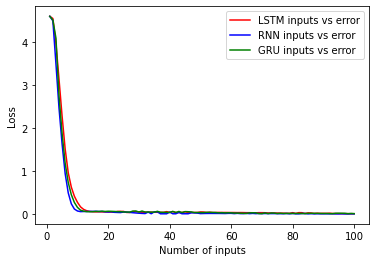

In [16]:
plt.plot(lstm_num_inputs[0:100],lstm_input_loss[0:100], color='r')
plt.plot(rnn_num_inputs[0:100],rnn_input_loss[0:100],color='b')
plt.plot(gru_num_inputs[0:100],gru_input_loss[0:100],color='g')

plt.legend(['LSTM inputs vs error', 'RNN inputs vs error', 'GRU inputs vs error'])
plt.xlabel('Number of inputs')
plt.ylabel('Loss')
plt.show()


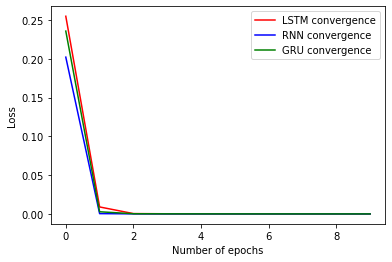

In [17]:
plt.plot(lstm_step_lis,lstm_loss_lis, color='r')
plt.plot(rnn_step_lis,rnn_loss_lis,color='b')
plt.plot(gru_step_lis,gru_loss_lis,color='g')

plt.legend(['LSTM convergence', 'RNN convergence', 'GRU convergence'])
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.show()

### Does RNN based model takes longer time to converge than GRU or LSTM. Show using the errorconvergence plot.
#### Answer:
 - As per the graph shown above, RNN seems to converge the fastest, followed by GRU and lastly LSTM
 - The loss (cross entropy) also seems to follow the trend: RNN < GRU < LSTM

In [18]:
# testing
# generate 3000 training samples in batches of size 1 for both x and y sequences
p = 100 # time steps
n_batches = 3000
batch_size = 1
num_trials = 10

# get inputs and labels
test_inputs_x,test_labels_x,test_inputs_y,test_labels_y = generate_inputs_labels(p, n_batches, batch_size)

In [19]:
# testing rnn
print("===RNN Test===")
with torch.no_grad():
    for trial in range(num_trials):
        n_correct = 0
        n_samples = 0
        for i in range(len(inputs_x)):
            if np.random.choice([0,1]) == 0:
                inp = test_inputs_x[i]
                lab = test_labels_x[i]
            else:
                inp = test_inputs_y[i]
                lab = test_labels_y[i]
            
            # forward
            outputs =  model_rnn(inp)
            loss = criterion(outputs, lab)
            # value, index
            _, prediction = torch.max(outputs, 1)
            n_samples += lab.shape[1]
            n_correct += (prediction == lab).sum().item()
        
        acc = 100.0 * n_correct / n_samples
        print(f'accuracy in trial {trial+1} of {num_trials}: {acc}')

===RNN Test===
accuracy in trial 1 of 10: 100.0
accuracy in trial 2 of 10: 100.0
accuracy in trial 3 of 10: 100.0
accuracy in trial 4 of 10: 100.0
accuracy in trial 5 of 10: 100.0
accuracy in trial 6 of 10: 100.0
accuracy in trial 7 of 10: 100.0
accuracy in trial 8 of 10: 100.0
accuracy in trial 9 of 10: 100.0
accuracy in trial 10 of 10: 100.0


In [20]:
# testing lstm
print("===LSTM Test===")
with torch.no_grad():
    for trial in range(num_trials):
        n_correct = 0
        n_samples = 0
        for i in range(len(inputs_x)):
            if np.random.choice([0,1]) == 0:
                inp = test_inputs_x[i]
                lab = test_labels_x[i]
            else:
                inp = test_inputs_y[i]
                lab = test_labels_y[i]
            
            # forward
            outputs =  model_lstm(inp)
            loss = criterion(outputs, lab)
            # value, index
            _, prediction = torch.max(outputs, 1)
            n_samples += lab.shape[1]
            n_correct += (prediction == lab).sum().item()
        
        acc = 100.0 * n_correct / n_samples
        print(f'accuracy in trial {trial+1} of {num_trials}: {acc}')

===LSTM Test===
accuracy in trial 1 of 10: 100.0
accuracy in trial 2 of 10: 100.0
accuracy in trial 3 of 10: 100.0
accuracy in trial 4 of 10: 100.0
accuracy in trial 5 of 10: 100.0
accuracy in trial 6 of 10: 100.0
accuracy in trial 7 of 10: 100.0
accuracy in trial 8 of 10: 100.0
accuracy in trial 9 of 10: 100.0
accuracy in trial 10 of 10: 100.0


In [21]:
# testing gru
print("===GRU Test===")
with torch.no_grad():
    for trial in range(num_trials):
        n_correct = 0
        n_samples = 0
        for i in range(len(inputs_x)):
            if np.random.choice([0,1]) == 0:
                inp = test_inputs_x[i]
                lab = test_labels_x[i]
            else:
                inp = test_inputs_y[i]
                lab = test_labels_y[i]
            
            # forward
            outputs =  model_gru(inp)
            loss = criterion(outputs, lab)
            # value, index
            _, prediction = torch.max(outputs, 1)
            n_samples += lab.shape[1]
            n_correct += (prediction == lab).sum().item()
        
        acc = 100.0 * n_correct / n_samples
        print(f'accuracy in trial {trial+1} of {num_trials}: {acc}')

===GRU Test===
accuracy in trial 1 of 10: 100.0
accuracy in trial 2 of 10: 100.0
accuracy in trial 3 of 10: 100.0
accuracy in trial 4 of 10: 100.0
accuracy in trial 5 of 10: 100.0
accuracy in trial 6 of 10: 100.0
accuracy in trial 7 of 10: 100.0
accuracy in trial 8 of 10: 100.0
accuracy in trial 9 of 10: 100.0
accuracy in trial 10 of 10: 100.0


### Average number of wrong predictions over 10 trials
 #### RNN
   - Prediction Accuracy is 100% over 10 trials
   - Average number of wrong predictions is 0 over 10 trials (this has been confirmed by manually checking values and comparing labels as well)

#### LSTM
   - Prediction Accuracy is 100% over 10 trials
   - Average number of wrong predictions is 0 over 10 trials (this has been confirmed by manually checking values and comparing labels as well)
   
#### GRU
   - Prediction Accuracy is 100% over 10 trials
   - Average number of wrong predictions is 0 over 10 trials (this has been confirmed by manually checking values and comparing labels as well)
 
 


# Question 2, Detecting Temporal order
### Run the code from here on separately

In [22]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [35]:
# hyper parameters
input_size = 8 # we have a p+1 dimensional vector for each time step
hidden_size = 2
num_epochs = 3
learning_rate = 0.1
n_classes = 8

In [36]:
class RecurrentNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RecurrentNeuralNet, self).__init__()
        self.rnn1 = nn.RNN(input_size=input_size,hidden_size=hidden_size,batch_first=True)
        self.rnn2 = nn.RNN(input_size=hidden_size,hidden_size=4,batch_first=True)
        self.rnn3 = nn.RNN(input_size=4,hidden_size=8,batch_first=True)
        
        self.l1 = nn.Linear(8, n_classes)
    
    def forward(self, x):
        out,h_n = self.rnn1(x)
        out,h_n = self.rnn2(out)
        out,h_n = self.rnn3(out)
        out = self.l1(out)
        
        return out


In [37]:
class LSTMNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMNeuralNet, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_size,hidden_size=hidden_size,batch_first=True)
        self.lstm2 = nn.LSTM(input_size=hidden_size,hidden_size=4,batch_first=True)
        self.lstm3 = nn.LSTM(input_size=4,hidden_size=8,batch_first=True)
        
        self.l1 = nn.Linear(8, n_classes)
    
    def forward(self, x):
        out,(h_n,c_n) = self.lstm1(x)
        out,(h_n,c_n) = self.lstm2(out)
        out,(h_n,c_n) = self.lstm3(out)
        
        out = self.l1(out)
        
        return out


In [38]:
class AttnRecurrentNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(AttnRecurrentNeuralNet, self).__init__()
        self.rnn1 = nn.RNN(input_size=input_size,hidden_size=hidden_size,batch_first=True)
        self.rnn2 = nn.RNN(input_size=hidden_size,hidden_size=4,batch_first=True)
        self.rnn3 = nn.RNN(input_size=4,hidden_size=8,batch_first=True)
        self.cos = nn.CosineSimilarity(dim=2, eps=1e-6)
        self.sig = nn.Sigmoid()
        self.l1 = nn.Linear(8, n_classes)
    
    def forward(self, x):
        out,h_n = self.rnn1(x)
        out,h_n = self.rnn2(out)
        out,h_n = self.rnn3(out) # O_T vector
        e = self.cos(out, x)

        
        alpha = torch.transpose(torch.div(torch.transpose(self.sig(e),0,1),torch.sum(self.sig(e),1)),0,1) # attention weights

        out = self.l1((x*alpha.unsqueeze(-1)))
        
        return out


In [39]:
# create one hot encodings
def generate_inputs_labels(n_batches, batch_size):
    encodings = {'E' : 0, 'a' : 1, 'b' : 2, 'c' : 3, 'd' : 4, 'X' : 5, 'Y' : 6, 'B' : 7}
    labels = ['XXX'  , 'XXY'  , 'XYX'  , 'XYY' , 'YXX'  , 'YXY'  , 'YYX'  , 'YYY' ]

    input_lis = []
    label_lis = []
    for i in range(n_batches):
        input_lis.append([])
        label_lis.append([])

        for k in range(batch_size):
            input_lis[i].append([])
            label_lis[i].append([])

            seq_len = np.random.randint(100,111)
            t1 = np.random.randint(9,20)
            t2 = np.random.randint(32,43)
            t3 = np.random.randint(65,76)
            label = np.random.choice(labels)
            if seq_len < 110:                                                     
                for j in range(seq_len, 110):
                    input_lis[i][k].append(F.one_hot(torch.tensor(encodings['E']), len(encodings)).numpy())
            for j in range(seq_len):
                if j == 0:
                    c = 'E'
                elif j == t1:
                    c = label[0]
                elif j == t2:
                    c = label[1]
                elif j == t3:
                    c = label[2]
                elif j == seq_len-1:
                    c = 'B'
                else:
                    c = np.random.choice(['a','b','c','d'])
                input_lis[i][k].append(F.one_hot(torch.tensor(encodings[c]), len(encodings)).numpy())
            label_lis[i][k] = F.one_hot(torch.tensor(labels.index(label)), n_classes).numpy()   
            input_lis[i][k] = np.array(input_lis[i][k])
            label_lis[i][k] = np.array(label_lis[i][k])

        input_lis[i] = np.array(input_lis[i])
        label_lis[i] = np.array(label_lis[i])
    input_lis = np.array(input_lis)
    label_lis = np.array(label_lis)

    input_lis = torch.from_numpy(input_lis)
    label_lis = torch.from_numpy(label_lis)
    input_lis,label_lis = input_lis.type(torch.FloatTensor),label_lis.type(torch.LongTensor)
    return input_lis,label_lis

In [40]:
n_batches = 500
batch_size = 20

input_lis,label_lis = generate_inputs_labels(n_batches, batch_size)

In [41]:
print(input_lis.shape)

torch.Size([500, 20, 110, 8])


In [42]:
model_rnn = RecurrentNeuralNet(input_size, hidden_size)

# adjust network parameters
for name,param in model_rnn.named_parameters():
    if name == 'rnn1.bias_ih_l0':
        param.data = nn.parameter.Parameter(nn.init.constant_(param, -2.0))
    elif name == 'rnn3.bias_ih_l0':
        param.data = nn.parameter.Parameter(nn.init.constant_(param, -6.0))
    elif name == 'rnn2.bias_ih_l0':
        param.data = nn.parameter.Parameter(nn.init.constant_(param, -4.0))
    elif name == 'rnn1.bias_hh_l0' or name == 'rnn2.bias_hh_l0' or name == 'rnn3.bias_hh_l0':
        pass
    else:   
        param.data = nn.parameter.Parameter(nn.init.uniform_(param, -0.1,0.1))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=learning_rate)

In [43]:
# training_loop
rnn_loss_lis = []
rnn_step_lis = []
steps = 1
n_total_steps = len(input_lis)
for epoch in range(num_epochs):
    for i in range(len(input_lis)):
        
        # forward
        outputs =  model_rnn(input_lis[i])
        loss = criterion(outputs, label_lis[i])
        
        # backwards 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        steps += 1        
        if (i+1)%100 == 0:
            print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')    
            rnn_loss_lis.append(loss.item())
            rnn_step_lis.append(steps)


epoch 1 / 3, step 100/500, loss = 0.3839
epoch 1 / 3, step 200/500, loss = 0.3845
epoch 1 / 3, step 300/500, loss = 0.3833
epoch 1 / 3, step 400/500, loss = 0.3789
epoch 1 / 3, step 500/500, loss = 0.3806
epoch 2 / 3, step 100/500, loss = 0.3812
epoch 2 / 3, step 200/500, loss = 0.3826
epoch 2 / 3, step 300/500, loss = 0.3828
epoch 2 / 3, step 400/500, loss = 0.3788
epoch 2 / 3, step 500/500, loss = 0.3802
epoch 3 / 3, step 100/500, loss = 0.3914
epoch 3 / 3, step 200/500, loss = 0.4035
epoch 3 / 3, step 300/500, loss = 0.3727
epoch 3 / 3, step 400/500, loss = 0.3949
epoch 3 / 3, step 500/500, loss = 0.3900


In [44]:
model_lstm = LSTMNeuralNet(input_size, hidden_size)

# adjust network parameters
for name,param in model_lstm.named_parameters():
    if name == 'lstm1.bias_ih_l0':
        param.data = nn.parameter.Parameter(nn.init.constant_(param, -2.0))
    elif name == 'lstm3.bias_ih_l0':
        param.data = nn.parameter.Parameter(nn.init.constant_(param, -6.0))
    elif name == 'lstm2.bias_ih_l0':
        param.data = nn.parameter.Parameter(nn.init.constant_(param, -4.0))
    elif name == 'lstm1.bias_hh_l0' or name == 'lstm2.bias_hh_l0' or name == 'lstm3.bias_hh_l0':
        pass
    else:   
        param.data = nn.parameter.Parameter(nn.init.uniform_(param, -0.1,0.1))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=learning_rate)

In [45]:
# training_loop
lstm_loss_lis = []
lstm_step_lis = []
steps = 1
n_total_steps = len(input_lis)
for epoch in range(num_epochs):
    for i in range(len(input_lis)):
        
        # forward
        outputs =  model_lstm(input_lis[i])
        loss = criterion(outputs, label_lis[i])
        
        # backwards 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        steps += 1        
        if (i+1)%100 == 0:
            print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')    
            lstm_loss_lis.append(loss.item())
            lstm_step_lis.append(steps)


epoch 1 / 3, step 100/500, loss = 0.3818
epoch 1 / 3, step 200/500, loss = 0.3854
epoch 1 / 3, step 300/500, loss = 0.3812
epoch 1 / 3, step 400/500, loss = 0.3813
epoch 1 / 3, step 500/500, loss = 0.3843
epoch 2 / 3, step 100/500, loss = 0.3817
epoch 2 / 3, step 200/500, loss = 0.3853
epoch 2 / 3, step 300/500, loss = 0.3814
epoch 2 / 3, step 400/500, loss = 0.3808
epoch 2 / 3, step 500/500, loss = 0.3836
epoch 3 / 3, step 100/500, loss = 0.3820
epoch 3 / 3, step 200/500, loss = 0.3849
epoch 3 / 3, step 300/500, loss = 0.3818
epoch 3 / 3, step 400/500, loss = 0.3800
epoch 3 / 3, step 500/500, loss = 0.3827


In [46]:
model_AttnRnn = AttnRecurrentNeuralNet(input_size, hidden_size)

# adjust network parameters
for name,param in model_AttnRnn.named_parameters():
    if name == 'rnn1.bias_ih_l0':
        param.data = nn.parameter.Parameter(nn.init.constant_(param, -2.0))
    elif name == 'rnn3.bias_ih_l0':
        param.data = nn.parameter.Parameter(nn.init.constant_(param, -6.0))
    elif name == 'rnn2.bias_ih_l0':
        param.data = nn.parameter.Parameter(nn.init.constant_(param, -4.0))
    elif name == 'rnn1.bias_hh_l0' or name == 'rnn2.bias_hh_l0' or name == 'rnn3.bias_hh_l0':
        pass
    else:
        param.data = nn.parameter.Parameter(nn.init.uniform_(param, -0.1,0.1))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_AttnRnn.parameters(), lr=learning_rate)

In [47]:
# training_loop
AttnRnn_loss_lis = []
AttnRnn_step_lis = []
steps = 1
n_total_steps = len(input_lis)
for epoch in range(num_epochs):
    for i in range(len(input_lis)):
        
        # forward
        outputs =  model_AttnRnn(input_lis[i])
        loss = criterion(outputs, label_lis[i])
        
        # backwards 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        steps += 1        
        if (i+1)%100 == 0:
            print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')    
            AttnRnn_loss_lis.append(loss.item())
            AttnRnn_step_lis.append(steps)


epoch 1 / 3, step 100/500, loss = 4.4759
epoch 1 / 3, step 200/500, loss = 4.2584
epoch 1 / 3, step 300/500, loss = 4.0724
epoch 1 / 3, step 400/500, loss = 3.8885
epoch 1 / 3, step 500/500, loss = 3.7225
epoch 2 / 3, step 100/500, loss = 3.5577
epoch 2 / 3, step 200/500, loss = 3.4021
epoch 2 / 3, step 300/500, loss = 3.1913
epoch 2 / 3, step 400/500, loss = 3.0365
epoch 2 / 3, step 500/500, loss = 2.9381
epoch 3 / 3, step 100/500, loss = 2.7834
epoch 3 / 3, step 200/500, loss = 2.5371
epoch 3 / 3, step 300/500, loss = 2.2884
epoch 3 / 3, step 400/500, loss = 2.2198
epoch 3 / 3, step 500/500, loss = 2.1939


### How many input sequences were generated in the training phase before it meets the stopping condition
#### Answer:
#### RNN
 - We ran the network with a variety of differnet batch sizes and number of batches with the initial configuration consisting of 3200 input sequences (100 batches of size 32) run for 10 epochs.
 - The loss seemed to stop reducing at 0.37 following which it fluctuated between 0.37 and 0.38
 - The model was run again with 10000 input sequences (500 batches of size 20) with the loss behaving in the same way.
 - As an additonal step, I put all the temporal values responsible for determining the sequence i.e., X,Y, at the sequence end in one trial and at the beginging in one trial with no improvements, the model seemed to learn nothing.
 - The RNN and RNN+attention model was run over 600 times with adjusted parameters and variations of test sequences, including constant sequence length, paddings at various locations, using zero padding as well as padding with the start symbol at both the beginging and the end with the same result.
 - We used the RNN from the previous question with 1, 2 and 3 layers and hidden size set to 128 followed by a linear layer with no improvement.
 - We tested with softmax activation and obtained worse results, loss stabalized at 0.9 with adhoc predictions.
 - We tested by removing the linear layer and obtained worse results.
 
#### LSTM
 - We ran the network with a variety of differnet batch sizes and number of batches with the initial configuration consisting of 3200 input sequences (100 batches of size 32) run for 10 epochs.
 - The loss seemed to stop reducing at 0.37 following which it fluctuated between 0.37 and 0.38
 - The model was run again with 10000 input sequences (500 batches of size 20) with the loss behaving in the same way.
 
#### RNN+Attention 
 - Attention mechanism was applied by following the paper, we first calculated the $e_i$ as the cosine similarity score between input symbol embedding (one-hot) $V_i$ and the network output at time T $O_T$ as $O_T \odot V_i$, these were calculated for each batch.
 - After this, we calculated the Attention weights by taking the sigmoid of the $e_i$ scores over the sum of all $e_i's$ over $T$, the total number of sequences  as $ \frac{\sigma(e_i)}{\sum_{i=1}^{T}{\sigma(e_i)}}$
 - Finally, before sending to a fully connected linear layer, we multipy each embedding $V_i$ with the corresponding $\alpha_i$ and take the sum, note that this is done over an entire batch of size 20.
 - The network was run with 10000 input sequences (500 batches of size 20) for over 30 epochs, However convergence was not achieved.
 - The loss seemed to reduce constantly for the first 20 epochs after which its minimum stabilized at around 0.6, fluctuation between 0.56 and 0.8

### Plot the number of input sequences passed through the network versus training error (for RNN, LSTM and RNN+Attention)

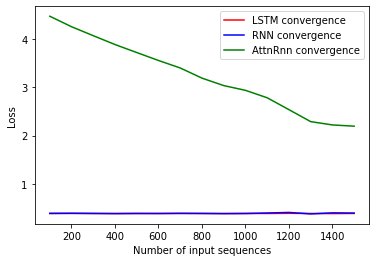

In [48]:
plt.plot(lstm_step_lis,lstm_loss_lis, color='r')
plt.plot(rnn_step_lis,rnn_loss_lis,color='b')
plt.plot(AttnRnn_step_lis,AttnRnn_loss_lis,color='g')

plt.legend(['LSTM convergence', 'RNN convergence', 'AttnRnn convergence'])
plt.xlabel('Number of input sequences')
plt.ylabel('Loss')
plt.show()

### Testing
### Report the average number of wrong predictions on the test set in 10 different trials (for RNN, LSTM and RNN+Attention using 3000 test sequences)

In [49]:
# generate 3000 test sequences
n_batches = 3000
batch_size = 1
num_trials = 10
test_input_lis,test_label_lis = generate_inputs_labels(n_batches, batch_size)


In [50]:
# testing rnn
print("===RNN Test===")
with torch.no_grad():
    for trial in range(num_trials):
        n_correct = 0
        n_samples = 0
        for i in range(len(test_input_lis)):
            
            # forward
            outputs =  model_rnn(test_input_lis[i])
            loss = criterion(outputs, test_label_lis[i])
            # value, index|
            _, prediction = torch.max(outputs, 1)
            n_samples += test_label_lis[i].shape[1]
            if (prediction == test_label_lis[i]).sum().item() == 8:
                n_correct += (prediction == test_label_lis[i]).sum().item()
            else:
                n_correct += 0
        acc = 100.0 * n_correct / n_samples
        print(f'accuracy in trial {trial+1} of {num_trials}: {acc}')

===RNN Test===
accuracy in trial 1 of 10: 0.0
accuracy in trial 2 of 10: 0.0
accuracy in trial 3 of 10: 0.0
accuracy in trial 4 of 10: 0.0
accuracy in trial 5 of 10: 0.0
accuracy in trial 6 of 10: 0.0
accuracy in trial 7 of 10: 0.0
accuracy in trial 8 of 10: 0.0
accuracy in trial 9 of 10: 0.0
accuracy in trial 10 of 10: 0.0


In [51]:
# testing lstm
print("===LSTM Test===")
with torch.no_grad():
    for trial in range(num_trials):
        n_correct = 0
        n_samples = 0
        for i in range(len(test_input_lis)):
            
            # forward
            outputs =  model_lstm(test_input_lis[i])
            loss = criterion(outputs, test_label_lis[i])
            # value, index|
            _, prediction = torch.max(outputs, 1)
            
            n_samples += test_label_lis[i].shape[1]
            if (prediction == test_label_lis[i]).sum().item() == 8:
                n_correct += (prediction == test_label_lis[i]).sum().item()
            else:
                n_correct += 0
        acc = 100.0 * n_correct / n_samples
        print(f'accuracy in trial {trial+1} of {num_trials}: {acc}')

===LSTM Test===
accuracy in trial 1 of 10: 0.0
accuracy in trial 2 of 10: 0.0
accuracy in trial 3 of 10: 0.0
accuracy in trial 4 of 10: 0.0
accuracy in trial 5 of 10: 0.0
accuracy in trial 6 of 10: 0.0
accuracy in trial 7 of 10: 0.0
accuracy in trial 8 of 10: 0.0
accuracy in trial 9 of 10: 0.0
accuracy in trial 10 of 10: 0.0


In [52]:
# testing Attention RNN
print("===Attention+RNN Test===")
with torch.no_grad():
    for trial in range(num_trials):
        n_correct = 0
        n_samples = 0
        for i in range(len(test_input_lis)):
            
            # forward
            outputs =  model_AttnRnn(test_input_lis[i])
            loss = criterion(outputs, test_label_lis[i])
            # value, index|
            _, prediction = torch.max(outputs, 1)
            
            n_samples += test_label_lis[i].shape[1]
            if (prediction == test_label_lis[i]).sum().item() == 8:
                n_correct += (prediction == test_label_lis[i]).sum().item()
            else:
                n_correct += 0

        acc = 100.0 * n_correct / n_samples
        print(f'accuracy in trial {trial+1} of {num_trials}: {acc}')

===Attention+RNN Test===
accuracy in trial 1 of 10: 0.0
accuracy in trial 2 of 10: 0.0
accuracy in trial 3 of 10: 0.0
accuracy in trial 4 of 10: 0.0
accuracy in trial 5 of 10: 0.0
accuracy in trial 6 of 10: 0.0
accuracy in trial 7 of 10: 0.0
accuracy in trial 8 of 10: 0.0
accuracy in trial 9 of 10: 0.0
accuracy in trial 10 of 10: 0.0


#### Average number of wrong predictions:
To convert the outputs to meaningful one-hot vectors we use determine the index of the max values as follows:

$$ \_, prediction = torch.max(outputs, 1) $$

#### RNN
 - Our RNN seems to predict all 0s and the accuracy is thus 0%.
 
#### LSTM
 - Our LSTM seems to predict all 0s and the accuracy is thus 0%.

#### RNN+Attention
 - Our RNN+Attention seems to predict all 0s and the accuracy is thus 0%.

All of these models were run with a wide variety of hyperparameters and tested as described previously but only adhoc predictions were obtained as if the network learned nothing, convergence was never attained by either of the models.